# LSTM

#### 데이터 준비

In [14]:
VOCAB_SIZE = 300  # 사용할 단어 수
SEQ_LEN = 100     # 스퀀스 하나

In [15]:
from tensorflow.keras.datasets import imdb

(train_input, train_target), (test_input, test_target) = imdb.load_data(num_words=VOCAB_SIZE)

In [16]:
import torch

train_input = [torch.tensor(seq, dtype=torch.long) for seq in train_input]
test_input = [torch.tensor(seq, dtype=torch.long) for seq in test_input]

train_target = torch.tensor(train_target, dtype=torch.long)
test_target = torch.tensor(test_target, dtype=torch.long)

print(len(train_input), len(test_target))
print(train_target.shape, test_target.shape)

25000 25000
torch.Size([25000]) torch.Size([25000])


In [17]:
train_input, test_input = train_input[:10000], test_input[:5000]
train_target, test_target = train_target[:10000], test_target[:5000]

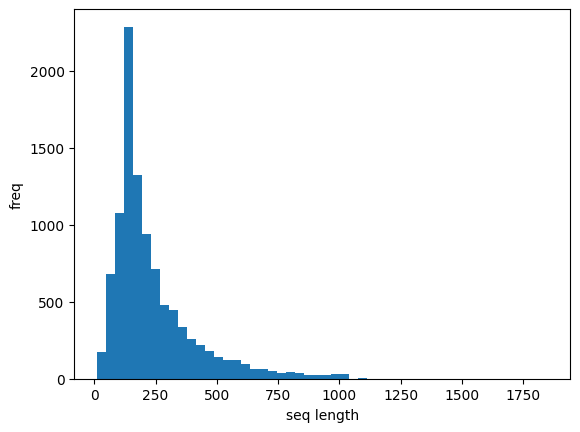

In [18]:
# 입력 데이터 길이 체크
import matplotlib.pyplot as plt
import numpy as np

train_len = [len(seq) for seq in train_input]

plt.hist(train_len, bins=50)
plt.xlabel('seq length')
plt.ylabel('freq')
plt.show()

In [19]:
# padding 처리
import torch.nn.functional as F

def pad_sequences(sequences, maxlen, padding_value=0):
  padded_sequence = [F.pad(seq[:maxlen], (0, max(0, maxlen-len(seq))), value=padding_value) for seq in sequences]
  return torch.stack(padded_sequence)

train_seq = pad_sequences(train_input, maxlen=SEQ_LEN)
test_seq = pad_sequences(test_input, maxlen=SEQ_LEN)

train_seq.shape, test_seq.shape

(torch.Size([10000, 100]), torch.Size([5000, 100]))

In [20]:
# one-hot encoding
train_onehot = F.one_hot(train_seq, num_classes=VOCAB_SIZE).float()
test_onehot = F.one_hot(test_seq, num_classes=VOCAB_SIZE).float()

train_onehot.shape, test_onehot.shape

(torch.Size([10000, 100, 300]), torch.Size([5000, 100, 300]))

### 모델 준비 및 학습

##### one-hot encoding + LSTM

In [25]:
import torch
import torch.nn as nn

class SentimentLSTM(nn.Module):
  def __init__(self, seq_len, vocab_size, hidden_dim, output_dim):
    super(SentimentLSTM, self).__init__()
    self.lstm = nn.LSTM(input_size=vocab_size, hidden_size=hidden_dim, batch_first=True)
    self.fc = nn.Linear(hidden_dim, output_dim)
    self.sigmoid = nn.Sigmoid()


  def forward(self,x):
    _, (hidden, _) = self.lstm(x)
    out = self.fc(hidden[-1])
    return self.sigmoid(out)

In [28]:
HIDDEN_DIM = 8
OUTPUT_DIM = 1

lstm_model = SentimentLSTM(seq_len=SEQ_LEN, vocab_size=VOCAB_SIZE, hidden_dim=HIDDEN_DIM, output_dim=OUTPUT_DIM)

print(lstm_model)

SentimentLSTM(
  (lstm): LSTM(300, 8, batch_first=True)
  (fc): Linear(in_features=8, out_features=1, bias=True)
  (sigmoid): Sigmoid()
)


In [29]:
total_params = 0
print(f"{'Layer':<20}{'Shape':<30}{'Params'}")
print("=" * 60)

for name, param in lstm_model.named_parameters():
  if param.requires_grad:
    param_count = param.numel()
    total_params += param_count
    print(f"{name:<20}{str(param.shape):<30}{param_count}")

print("=" * 60)
print(f"Total Trainable P arameters: {total_params}")

Layer               Shape                         Params
lstm.weight_ih_l0   torch.Size([32, 300])         9600
lstm.weight_hh_l0   torch.Size([32, 8])           256
lstm.bias_ih_l0     torch.Size([32])              32
lstm.bias_hh_l0     torch.Size([32])              32
fc.weight           torch.Size([1, 8])            8
fc.bias             torch.Size([1])               1
Total Trainable P arameters: 9929


Epoch 1/100 | Train Loss: 0.6927, Train Acc: 0.5075, Val Loss: 0.6930, Val Acc: 0.5100
Epoch 2/100 | Train Loss: 0.6916, Train Acc: 0.5259, Val Loss: 0.6923, Val Acc: 0.5110
Epoch 3/100 | Train Loss: 0.6905, Train Acc: 0.5333, Val Loss: 0.6911, Val Acc: 0.5215
Epoch 4/100 | Train Loss: 0.6883, Train Acc: 0.5514, Val Loss: 0.6861, Val Acc: 0.5635
Epoch 5/100 | Train Loss: 0.6630, Train Acc: 0.6081, Val Loss: 0.6426, Val Acc: 0.6385
Epoch 6/100 | Train Loss: 0.6352, Train Acc: 0.6501, Val Loss: 0.6140, Val Acc: 0.6845
Epoch 7/100 | Train Loss: 0.5972, Train Acc: 0.6954, Val Loss: 0.6485, Val Acc: 0.6470
Epoch 8/100 | Train Loss: 0.5797, Train Acc: 0.7100, Val Loss: 0.5759, Val Acc: 0.7040
Epoch 9/100 | Train Loss: 0.5736, Train Acc: 0.7170, Val Loss: 0.5699, Val Acc: 0.7155
Epoch 10/100 | Train Loss: 0.5569, Train Acc: 0.7289, Val Loss: 0.5628, Val Acc: 0.7200
Epoch 11/100 | Train Loss: 0.5554, Train Acc: 0.7268, Val Loss: 0.5628, Val Acc: 0.7105
Epoch 12/100 | Train Loss: 0.5351, Train 

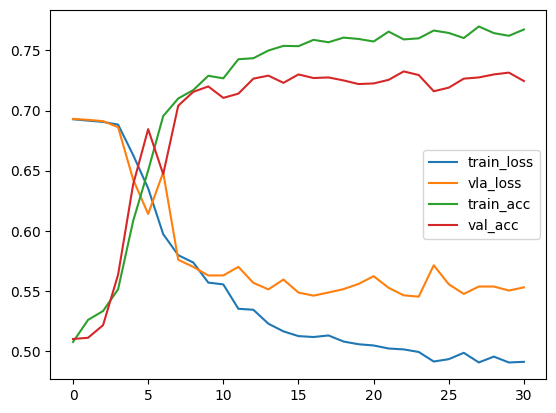

In [30]:
import torch.optim as optim
import pandas as pd
from torch.utils.data import DataLoader, TensorDataset, random_split

# 배치 사이즈 설정 + 학습/검증셋 크기 설정
BATCH_SIZE = 65
train_size = int(len(train_onehot) * 0.8)
val_size = len(train_onehot) - train_size

# label 데이터 실수 처리
train_target = train_target.float()
test_target = test_target.float()

# 학습/검증셋 분할 + 미니배치 사용하도록 DataLoader 생성
train_dataset, val_dataset = random_split(TensorDataset(train_onehot, train_target), [train_size, val_size])
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE)

# epoch, 손실함수, 최적화함수 정의
epochs = 100
criterion = nn.BCELoss()
optimizer = optim.Adam(lstm_model.parameters(), lr=0.001)

# 시각화를 위한 손길값, 정확도 저장용
train_losses, val_losses, train_accs, val_accs = [], [], [], []

# 조기종료 관련 변수 초기화
early_stopping_patience = 7
best_val_loss = float('inf')
early_stop_count = 0

# 학습과정
for epoch in range(epochs):
  # train mode
  lstm_model.train()
  total_loss, correct, total = 0, 0, 0

  for inputs, targets in train_loader:
    optimizer.zero_grad()             # 가중치 초기화
    outputs = lstm_model(inputs).squeeze() # 순전파

    loss = criterion(outputs,targets) # 손실 계산

    loss.backward()                   # 역전파
    optimizer.step()                  # 가중치 업데이트
    total_loss += loss.item()

    pred = (outputs > 0.5).float()
    correct += (pred == targets).sum().item()
    total += targets.size(0)

  train_loss = total_loss / len(train_loader)
  train_acc = correct / total
  train_losses.append(train_loss)
  train_accs.append(train_acc)

  # validation mode
  lstm_model.eval()
  val_loss, val_correct, val_total = 0, 0, 0

  with torch.no_grad():
    for val_inputs, val_targets in val_loader:
      val_outputs = lstm_model(val_inputs).squeeze() # 순전파
      loss = criterion(val_outputs,val_targets) # 손실 계산
      val_loss += loss.item()

      val_pred = (val_outputs > 0.5).float()
      val_correct += (val_pred == val_targets).sum().item()
      val_total += val_targets.size(0)

  val_loss = val_loss / len(val_loader)
  val_acc = val_correct / val_total
  val_losses.append(val_loss)
  val_accs.append(val_acc)

  print(f'Epoch {epoch+1}/{epochs} | Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}, Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}')

  # 조기종료 처리
  if val_loss < best_val_loss:
    best_val_loss = val_loss
    early_stopping_counter = 0

  else:
    early_stopping_counter +=1
    if early_stopping_counter >= early_stopping_patience:
      print("Early stopping")
      break

# 시각화
train_history_df = pd.DataFrame({
    'train_loss': train_losses,
    'vla_loss' : val_losses,
    'train_acc': train_accs,
    'val_acc': val_accs
})
train_history_df.plot()
plt.show()

In [31]:
def evaluate_model(model, test_loader, criterion):
  lstm_model.eval()
  val_loss, val_correct, val_total = 0, 0, 0

  with torch.no_grad():
    for val_inputs, val_targets in test_loader:
      val_outputs = lstm_model(val_inputs).squeeze() # 순전파
      loss = criterion(val_outputs,val_targets) # 손실 계산
      val_loss += loss.item()

      val_pred = (val_outputs > 0.5).float()
      val_correct += (val_pred == val_targets).sum().item()
      val_total += val_targets.size(0)

  test_loss = val_loss / len(test_loader)
  test_acc = val_correct / val_total
  return test_loss, test_acc

In [32]:
test_dataset = TensorDataset(test_onehot, test_target)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE)

test_loss, test_acc = evaluate_model(lstm_model, test_loader, criterion)
print(f'Test Loss: {test_loss:.4f}, Test Acc: {test_acc:.4f}')

Test Loss: 0.5600, Test Acc: 0.7230


##### Embedding + LSTM

In [39]:
import torch
import torch.nn as nn

class SentimentLSTM(nn.Module):
  def __init__(self, vocab_size, embedding_dim, hidden_dim, output_dim):
    super(SentimentLSTM, self).__init__()
    self.embedding = nn.Embedding(num_embeddings=vocab_size, embedding_dim = embedding_dim)
    self.lstm = nn.LSTM(input_size=embedding_dim, hidden_size=hidden_dim, batch_first=True)
    self.fc = nn.Linear(hidden_dim, output_dim)
    self.sigmoid = nn.Sigmoid()


  def forward(self,x):
    x = self.embedding(x)
    _, (hidden, _) = self.lstm(x)
    out = self.fc(hidden[-1])
    return self.sigmoid(out)

In [40]:
HIDDEN_DIM = 8
OUTPUT_DIM = 1
EMBEDDING_DIM = 50

ebd_lstm_model = SentimentLSTM(vocab_size=VOCAB_SIZE, embedding_dim=EMBEDDING_DIM, hidden_dim=HIDDEN_DIM, output_dim=OUTPUT_DIM)

print(ebd_lstm_model)

SentimentLSTM(
  (embedding): Embedding(300, 50)
  (lstm): LSTM(50, 8, batch_first=True)
  (fc): Linear(in_features=8, out_features=1, bias=True)
  (sigmoid): Sigmoid()
)


In [41]:
total_params = 0
print(f"{'Layer':<20}{'Shape':<30}{'Params'}")
print("=" * 60)

for name, param in ebd_lstm_model.named_parameters():
  if param.requires_grad:
    param_count = param.numel()
    total_params += param_count
    print(f"{name:<20}{str(param.shape):<30}{param_count}")

print("=" * 60)
print(f"Total Trainable P arameters: {total_params}")

Layer               Shape                         Params
embedding.weight    torch.Size([300, 50])         15000
lstm.weight_ih_l0   torch.Size([32, 50])          1600
lstm.weight_hh_l0   torch.Size([32, 8])           256
lstm.bias_ih_l0     torch.Size([32])              32
lstm.bias_hh_l0     torch.Size([32])              32
fc.weight           torch.Size([1, 8])            8
fc.bias             torch.Size([1])               1
Total Trainable P arameters: 16929


Epoch 1/100 | Train Loss: 0.6933, Train Acc: 0.5102, Val Loss: 0.6928, Val Acc: 0.5105
Epoch 2/100 | Train Loss: 0.6839, Train Acc: 0.5569, Val Loss: 0.6880, Val Acc: 0.5590
Epoch 3/100 | Train Loss: 0.6570, Train Acc: 0.6140, Val Loss: 0.6761, Val Acc: 0.5900
Epoch 4/100 | Train Loss: 0.6257, Train Acc: 0.6530, Val Loss: 0.6677, Val Acc: 0.6075
Epoch 5/100 | Train Loss: 0.6154, Train Acc: 0.6644, Val Loss: 0.6737, Val Acc: 0.6175
Epoch 6/100 | Train Loss: 0.5988, Train Acc: 0.6853, Val Loss: 0.6704, Val Acc: 0.6335
Epoch 7/100 | Train Loss: 0.5784, Train Acc: 0.7035, Val Loss: 0.6641, Val Acc: 0.6435
Epoch 8/100 | Train Loss: 0.5628, Train Acc: 0.7188, Val Loss: 0.6726, Val Acc: 0.6370
Epoch 9/100 | Train Loss: 0.5592, Train Acc: 0.7231, Val Loss: 0.6554, Val Acc: 0.6440
Epoch 10/100 | Train Loss: 0.5488, Train Acc: 0.7352, Val Loss: 0.7186, Val Acc: 0.6010
Epoch 11/100 | Train Loss: 0.5569, Train Acc: 0.7254, Val Loss: 0.6957, Val Acc: 0.6440
Epoch 12/100 | Train Loss: 0.5366, Train 

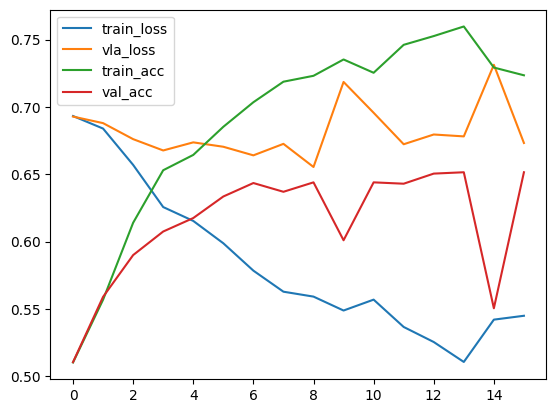

In [43]:
import torch.optim as optim
import pandas as pd
from torch.utils.data import DataLoader, TensorDataset, random_split

# 배치 사이즈 설정 + 학습/검증셋 크기 설정
BATCH_SIZE = 65
train_size = int(len(train_seq) * 0.8)
val_size = len(train_seq) - train_size

# label 데이터 실수 처리
train_target = train_target.to(torch.float32)
train_dataset, val_dataset = random_split(TensorDataset(train_seq.to(torch.long), train_target), [train_size, val_size])
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE)

# epoch, 손실함수, 최적화함수 정의
epochs = 100
criterion = nn.BCELoss()
optimizer = optim.Adam(ebd_lstm_model.parameters(), lr=0.01)

# 시각화를 위한 손길값, 정확도 저장용
train_losses, val_losses, train_accs, val_accs = [], [], [], []

# 조기종료 관련 변수 초기화
early_stopping_patience = 7
best_val_loss = float('inf')
early_stop_count = 0

# 학습과정
for epoch in range(epochs):
  # train mode
  ebd_lstm_model.train()
  total_loss, correct, total = 0, 0, 0

  for inputs, targets in train_loader:
    optimizer.zero_grad()             # 가중치 초기화
    outputs = ebd_lstm_model(inputs).squeeze() # 순전파

    loss = criterion(outputs,targets) # 손실 계산

    loss.backward()                   # 역전파
    optimizer.step()                  # 가중치 업데이트
    total_loss += loss.item()

    pred = (outputs > 0.5).float()
    correct += (pred == targets).sum().item()
    total += targets.size(0)

  train_loss = total_loss / len(train_loader)
  train_acc = correct / total
  train_losses.append(train_loss)
  train_accs.append(train_acc)

  # validation mode
  ebd_lstm_model.eval()
  val_loss, val_correct, val_total = 0, 0, 0

  with torch.no_grad():
    for val_inputs, val_targets in val_loader:
      val_outputs = ebd_lstm_model(val_inputs).squeeze() # 순전파
      loss = criterion(val_outputs,val_targets) # 손실 계산
      val_loss += loss.item()

      val_pred = (val_outputs > 0.5).float()
      val_correct += (val_pred == val_targets).sum().item()
      val_total += val_targets.size(0)

  val_loss = val_loss / len(val_loader)
  val_acc = val_correct / val_total
  val_losses.append(val_loss)
  val_accs.append(val_acc)

  print(f'Epoch {epoch+1}/{epochs} | Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}, Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}')

  # 조기종료 처리
  if val_loss < best_val_loss:
    best_val_loss = val_loss
    early_stopping_counter = 0

  else:
    early_stopping_counter +=1
    if early_stopping_counter >= early_stopping_patience:
      print("Early stopping")
      break

# 시각화
train_history_df = pd.DataFrame({
    'train_loss': train_losses,
    'vla_loss' : val_losses,
    'train_acc': train_accs,
    'val_acc': val_accs
})
train_history_df.plot()
plt.show()

In [44]:
def evaluate_model(model, test_loader, criterion):
  ebd_lstm_model.eval()
  val_loss, val_correct, val_total = 0, 0, 0

  with torch.no_grad():
    for val_inputs, val_targets in test_loader:
      val_outputs = ebd_lstm_model(val_inputs).squeeze() # 순전파
      loss = criterion(val_outputs,val_targets) # 손실 계산
      val_loss += loss.item()

      val_pred = (val_outputs > 0.5).float()
      val_correct += (val_pred == val_targets).sum().item()
      val_total += val_targets.size(0)

  test_loss = val_loss / len(test_loader)
  test_acc = val_correct / val_total
  return test_loss, test_acc

In [46]:
test_dataset = TensorDataset(test_seq, test_target)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE)

test_loss, test_acc = evaluate_model(ebd_lstm_model, test_loader, criterion)
print(f'Test Loss: {test_loss:.4f}, Test Acc: {test_acc:.4f}')

Test Loss: 0.6690, Test Acc: 0.6500


### 입출력 shape

- return_sequences
- return_state
- Bidirectional LSTM/GRU

In [47]:
import numpy as np

B = 2   # batch_size
T = 5   # timestep
D = 10  # embedding_dim
U = 3   # unit(뉴런수)

x = np.random.randn(B, T, D)

##### return_sequences

- LSTM 다층 구조를 만들거나 다대다 구조의 출력이 필요한 시퀀스 예측/변환 작업에서 설정
  - False(기본값): 마지막 Timestep의 output만 반환
  - True: 도느 Timestep의 output의 변환

In [51]:
from tensorflow.keras import models, layers

def lstm(x, return_sequences=False):
  input = layers.Input(shape=(T, D))
  output = layers.LSTM(U, return_sequences=return_sequences)(input)
  model = models.Model(input, output)
  model.summary()
  return model.predict(x)

print(lstm(x, return_sequences=False).shape)
print(lstm(x, return_sequences=True).shape)

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)           │ (None, 5, 10)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_3 (LSTM)                        │ (None, 3)                   │             168 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 168 (672.00 B)

 Trainable params: 168 (672.00 B)

 Non-trainable params: 0 (0.00 B)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 288ms/step
(2, 3)


Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_4 (InputLayer)           │ (None, 5, 10)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_4 (LSTM)                        │ (None, 5, 3)                │             168 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 168 (672.00 B)

 Trainable params: 168 (672.00 B)

 Non-trainable params: 0 (0.00 B)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step
(2, 5, 3)


##### retrun_state

- Encoder-decoder 모델에서 Encoder의 학습된 hidden_state, cell_state를 Decoder의 초기 state 값으로 사용(context vector/thought vector)
  - False(기본값): LSTM의 output값만 변환
  - True: LSTM output, cell state, hidden state 모두 반환

In [53]:
from tensorflow.keras import models, layers

def lstm2(x, return_state=False):
  input = layers.Input(shape=(T, D))
  output = layers.LSTM(U, return_state=return_state)(input)
  model = models.Model(input, output)
  model.summary()
  return model.predict(x)

print(lstm2(x, return_state=False).shape)
# print(lstm2(x, return_state=True).shape)

output, hidden_state, cell_state = lstm2(x, return_state=True)
print(output.shape, hidden_state.shape, cell_state.shape)


Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_7 (InputLayer)           │ (None, 5, 10)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_7 (LSTM)                        │ (None, 3)                   │             168 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 168 (672.00 B)

 Trainable params: 168 (672.00 B)

 Non-trainable params: 0 (0.00 B)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 197ms/step
(2, 3)


Model: "functional_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_8 (InputLayer)           │ (None, 5, 10)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_8 (LSTM)                        │ [(None, 3), (None, 3),      │             168 │
│                                      │ (None, 3)]                  │                 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 168 (672.00 B)

 Trainable params: 168 (672.00 B)

 Non-trainable params: 0 (0.00 B)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step
(2, 3) (2, 3) (2, 3)


##### Birdirectional LSTM

In [55]:
def bi_lstm(x, return_sequences=False, return_state = False):
  input = layers.Input(shape=(T, D))
  lstm = layers.LSTM(U, return_sequences=return_sequences, return_state=return_state)
  output = layers.Bidirectional(lstm)(input)
  model = models.Model(inputs=input, outputs=output)
  model.summary()
  return model.predict(x)

output1 = bi_lstm(x)
print(output1.shape)

output2 = bi_lstm(x, return_sequences=True)
print(output2.shape)

output3, for_h_stt, for_c_stt, back_h_stt, back_c_stt = bi_lstm(x, return_state=True)
print(output3.shape, for_h_stt.shape, for_c_stt.shape, back_h_stt.shape, back_c_stt.shape)

Model: "functional_10"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_12 (InputLayer)          │ (None, 5, 10)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_3 (Bidirectional)      │ (None, 6)                   │             336 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 336 (1.31 KB)

 Trainable params: 336 (1.31 KB)

 Non-trainable params: 0 (0.00 B)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 356ms/step
(2, 6)


Model: "functional_11"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_13 (InputLayer)          │ (None, 5, 10)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_4 (Bidirectional)      │ (None, 5, 6)                │             336 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 336 (1.31 KB)

 Trainable params: 336 (1.31 KB)

 Non-trainable params: 0 (0.00 B)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 317ms/step
(2, 5, 6)


Model: "functional_12"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_14 (InputLayer)          │ (None, 5, 10)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_5 (Bidirectional)      │ [(None, 6), (None, 3),      │             336 │
│                                      │ (None, 3), (None, 3),       │                 │
│                                      │ (None, 3)]                  │                 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 336 (1.31 KB)

 Trainable params: 336 (1.31 KB)

 Non-trainable params: 0 (0.00 B)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 343ms/step
(2, 6) (2, 3) (2, 3) (2, 3) (2, 3)
